# Soil Moisture Sensor Design

## Summary
This notebook outlines a design for a capacitive soil moisture sensor. It uses a co-planar capacitor to detect capacitiance of the material around the sensor - in this case we are interested in soil and the water content. As the soil moisture content changes, the permitivity of the material changes. For example, the relative permitivity of air is around 1 and the permitivity of water is around 80. We will attempt to calculate the different capacitances expected for these changes and design a circuit to detect them. 

### Inspiration
The inspiration for this project comes from existing soil capacitance sensors - with the added challenge of creating an improved circuit that outputs a rail-to-rail voltage directly proportional to moisture - in other words, a voltage of 0 corresponds to the sensor in air, and and voltage of Vdd when the sensor is submerged in water.

## References:
* [Co-Planar Capacitance Calculator](https://www.emisoftware.com/calculator/coplanar-capacitance/)
* [Capacitive Soil Moisture Sensor](http://www.gikfun.com/belong-to-you-modules-c-68/capacitive-soil-moisture-sensor-corrosion-resistant-for-arduino-p-824.html)

In [ ]:
import sympy
import math
import numpy as np
import matplotlib.pyplot as plt

sympy.init_printing()

In [2]:
# create the co-planar capacitance functions using [this website](https://www.emisoftware.com/calculator/coplanar-capacitance/) as a guide
s, w, l, ξr = sympy.symbols('s w l ξr')

# s is the distance in m between the plates
# w is the width in m of the plates
# l is the length in m of the plates
condition = s / (s + 2 * w)

# speed of light in a vacuum, m/s
v0 = 299792548

eq = sympy.root(1 - (s**2/(s + 2*w)**2), 4)
denom = eq - 1
numer = eq + 1

cap1 = (ξr * l * sympy.ln((-2 / denom) * numer)) / (377 * sympy.pi * v0)
cap2 = (ξr * l) / (120 * v0 * sympy.ln((-2 * (sympy.root(condition, 2) + 1) ) / (sympy.root(condition, 2) - 1)))

def cp_cap(s, w, l, ξr):
    """
    Calculates the capacitance of a co-planar capacitor
    
    :param s: distance separating the plates in metres
    :param w: width of the plates in metres
    :param l: length of the plates in metres
    :param ξr: relative permitivity of the material surrounding the capacitor
    :return: capacitance in Farads
    """
    cond = condition.evalf(subs={'s': s, 'w': w, 'l': l, 'ξr': ξr})
    if cond < 0 or cond > 1:
        raise ValueError(f'We are expecting the condition to be between 0 and 1, but found {cond}')
    
    if cond <= (1 / math.sqrt(2)):
        return cap1.evalf(subs={'s': s, 'w': w, 'l': l, 'ξr': ξr})
    else:
        return cap2.evalf(subs={'s': s, 'w': w, 'l': l, 'ξr': ξr})

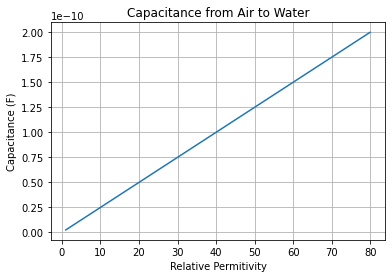

In [3]:
# plot the expected capacitance between air and water
s_val = 5e-4 # 0.5mm seperating the plates
w_val = 5e-3 # 5mm width of plates
l_val = 0.1 # 10cm length of plates

x_vals = np.linspace(1.0, 80.0)
y_vals = [cp_cap(s_val, w_val, l_val, x) for x in x_vals]

plt.figure()

plt.plot(x_vals, y_vals)
plt.xlabel('Relative Permitivity')
plt.ylabel('Capacitance (F)')
plt.grid(True)
plt.title('Capacitance from Air to Water')

plt.show()

In [4]:
# good news, it appears to be linear
air_cp = cp_cap(s_val, w_val, l_val, 1.0006)
water_cp = cp_cap(s_val, w_val, l_val, 80.0)
dry_soil_cp = cp_cap(s_val, w_val, l_val, 3.0)
print(f'Expected range from air to water: [{air_cp}, {water_cp}] F')

Expected range from air to water: [2.49693140512721E-12, 1.99634731571234E-10] F


We can estimate capacitance by detecting the gain across the sensor in an RC circuit when applying a square wave ([RC Circuit - Wikipedia](https://en.wikipedia.org/wiki/RC_circuit)).

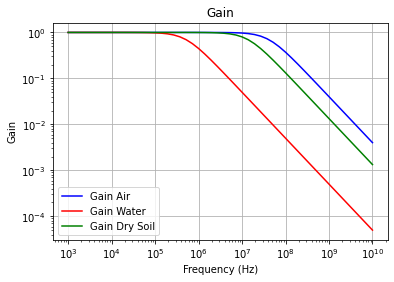

In [5]:
ω, R, C = sympy.symbols('ω R C')

Gc = 1 / (sympy.sqrt(1 + (ω * R * C)**2))

# bode plots to determine what frequency we should use
freqs = np.logspace(3, 10)

# resistance to use in the RC circuit for measurement
res = 10e3

gain_air = [Gc.evalf(subs={'R': res, 'C': air_cp, 'ω': f}) for f in freqs]
gain_water = [Gc.evalf(subs={'R': res, 'C': water_cp, 'ω': f}) for f in freqs]
gain_dry_soil = [Gc.evalf(subs={'R': res, 'C': dry_soil_cp, 'ω': f}) for f in freqs]

# bode plots
plt.plot(freqs, gain_air, 'b-', label='Gain Air')
plt.plot(freqs, gain_water, 'r-', label='Gain Water')
plt.plot(freqs, gain_dry_soil, 'g-', label='Gain Dry Soil')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.legend()

plt.grid(True)
plt.title('Gain')
plt.show()

From the above plot, we can choose a frequency that provides us with the most gain difference between air and water - somewhere around 10 MHz. This is based on ideal conditions and no other capacitances affecting the sensor.

To test the theory, I first created a very basic co-planar capacitory using copper tape and paper:

![Prototype Version 1](./res/img/prototypeV1.jpg "Prototype Version 1")

After I had proved the basic concept, I then created a PCB version (which I waterproofed with a varathane spray):

![Prototype Version 2](./res/img/prototypeV2.jpg "Prototype Version 2")

I then used a function generator and an oscilliscope to measure the gain loss of the signal when the sensor was submerged in water and also when it was in open air.

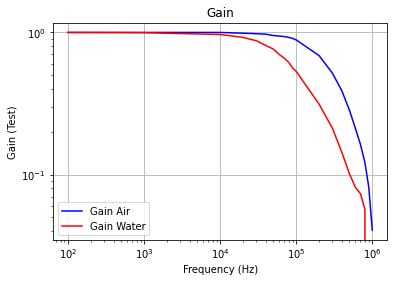

In [6]:
# actual measurements from paper prototype
test_freqs = np.array([1e2, 1e3, 1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 1e5, 2e5, 3e5, 4e5, 5e5, 6e5, 7e5, 8e5, 9e5, 1e6])

test_air_v = np.array([4.92, 4.92, 4.92, 4.86, 4.82, 4.78, 4.68, 4.64, 4.6, 4.54, 4.46, 4.36, 3.38, 2.54, 1.90, 1.4, 1.04, .8, .6, .4, .2])
test_air_g = np.divide(test_air_v, 4.92)

test_water_v = np.array([4.92, 4.90, 4.76, 4.54, 4.3, 3.98, 3.76, 3.44, 3.24, 3.02, 2.76, 2.62, 1.54, 1.04, 0.7, 0.5, 0.4, 0.36, 0.28, 0, 0])
test_water_g = np.divide(test_water_v, 4.92)

plt.plot(test_freqs, test_air_g, 'b-', label='Gain Air')
plt.plot(test_freqs, test_water_g, 'r-', label='Gain Water')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (Test)')
plt.legend()

plt.grid(True)
plt.title('Gain')
plt.show()

At this point, we can use Numpy functions to determine the frequency at which we see the largest gain difference:

In [7]:
dist = np.absolute(test_water_g - test_air_g)
max_index = np.argmax(dist)
print(f'Frequency to use: {test_freqs[max_index]} Hz')

Frequency to use: 200000.0 Hz


200 KHz is a huge difference from 10 MHz calculated in the ideal case. I suspect that my PCB sensors have manufacturing inaccuracies, as well as some parasitic capacitances. I am not a electronics engineer though and these reasons are speculative, so any feedback as to why this is the case would be welcomed!

## Circuit Design
Please refer to the following schematic for the next section:
![Circuit Schematic](./res/img/schematic.png "Circuit Schematic")


### Square Wave Generator
To generate a square wave frequency at 200 KHz, we can use a [555 timer (Wikipedia)](https://en.wikipedia.org/wiki/555_timer_IC). I used a rail-to-rail 555 timer, [TLC555CP (Digikey)](https://www.digikey.ca/en/products/detail/texas-instruments/TLC555CP/277502). Using a capacitance of 470pF, and a resistor combination of 1kΩ and 4.7kΩ, I found this resulted in a square wave with an actual frequency of 210kHz (calculators may give you closer to 300kHz but these timers behave different than calculated at higher frequencies) and a duty cycle close to 50%. The generated wave was between 0 volts and Vdd, where Vdd is approximately 5.5V from the power supply I was using.

### Sensor
The sensor is a capacitor, so we pass the generated signal through an RC circuit - I chose a 10kΩ resistor. The output is a typical RC response that varies based on the capacitance change when the moisture surround the sensor changes. The higher the moisture, the lower the peak to peak voltage becomes. The voltage is centred around half of Vdd.

### Rectification
The output is then passed through a diode and low pass filter to extract a constant voltage that varies from about 2.9V (when submerged in water) and 4.8V when in open air. This gives us a voltage range of about 2V to work with.

### Voltage Buffers
The measured voltage is then fed through a voltage buffer circuit, using an op-amp. 

**NOTE:** I used a quad op-amp [MCP6004 (Digikey)](https://www.digikey.ca/en/products/detail/microchip-technology/MCP6004-I-P/523060) of which I made use of all 4.

Another op-amp is used as a voltage buffer as well, but this one samples half of Vdd using a voltage divider, and is used in the next circuit.

### Differential Amplifier 
This amplifier simply takes the measured voltage, and subtracts off half of Vdd in order to get a signal that now varies from approximately 0.15 to 2.05 volts.

### Inverting Amplifier
Finally, we pass in the previous signal into an inverting amplifier that amplifies the inverted voltage by 1.8 times (from experimentation). We can now measure the voltage output and we will find that we have a voltage that varies from around 0 to Vdd, directly proportinal to the amount of moisture about the sensor. 

## Board Design
**NOTE:** In the following image, it appears there is no gap between the capacitor cathode and anode, when in reality there is. Please see the Eagle board and schematic files for finer details.

![Board](./res/img/board.png "Board")

## Results
Images of the final PCB sensor (again, the sensor portion was water-proofed using a varathane spray):

![PCB Front](./res/img/prototypeV3front.jpg "PCB Front")

![PCB Back](./res/img/prototypeV3back.jpg "PCB Back")

Images of the sensor at the extremes:

![PCB Front](./res/img/testair.jpg "Test in Air")

![PCB Back](./res/img/testwater.jpg "Test in Water")

## Other Notes
If using this sensor from a micro-controller, it is required that you only energize this circuit when you wish to sample the value. Otherwise, the operational amplifiers will saturate over time, and the output voltage will be Vdd. I recommended energizing for a few seconds, and then taking a sample, before shutting the sensor down until you need the next sample.